In [ ]:
# 내 구글 드라이브에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# 필요한 패키지와 모듈을 불러옴
import numpy as np
import dlib
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# eyes landmark 를 정의합니다.
RIGHT_EYE = list(range(36, 42))
LEFT_EYE = list(range(42, 48))
EYES = list(range(36, 48))

In [ ]:
predictor_file = 'gdrive/My Drive/CV/Face Landmark/shape_predictor_68_face_landmarks.dat'   # 이미 학습된 dlib 모델을 불러옴.
image_file = 'face.jpg'  # 원본 이미지 파일
OUTPUT_SIZE = (300, 300)   # output 이미지 해상도

In [ ]:
detector = dlib.get_frontal_face_detector()       # 얼굴을 감지하는 detector 정의
predictor = dlib.shape_predictor(predictor_file)  # facial landmark 을 찾아주는 predictor 정의

image = cv2.imread(image_file)  # 원본 이미지를 읽어옴
image_origin = image.copy()     # 원본 이미지 copy

(image_height, image_width) = image.shape[:2]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

rects = detector(gray, 1)  # detector 에 의해 얼굴 감지

In [ ]:
# rect 의 x, y, w, h 를 구하는 함수 정의
def getFaceDimension(rect):
    return (rect.left(), rect.top(), rect.right() - rect.left(), rect.bottom() - rect.top())

# Crop 할 좌표를 구하는 함수 정의
def getCropDimension(rect, center):
    width = (rect.right() - rect.left())
    half_width = width // 2
    (centerX, centerY) = center
    startX = centerX - half_width
    endX = centerX + half_width
    startY = rect.top()
    endY = rect.bottom() 
    return (startX, endX, startY, endY)  

==== face landmark image ====



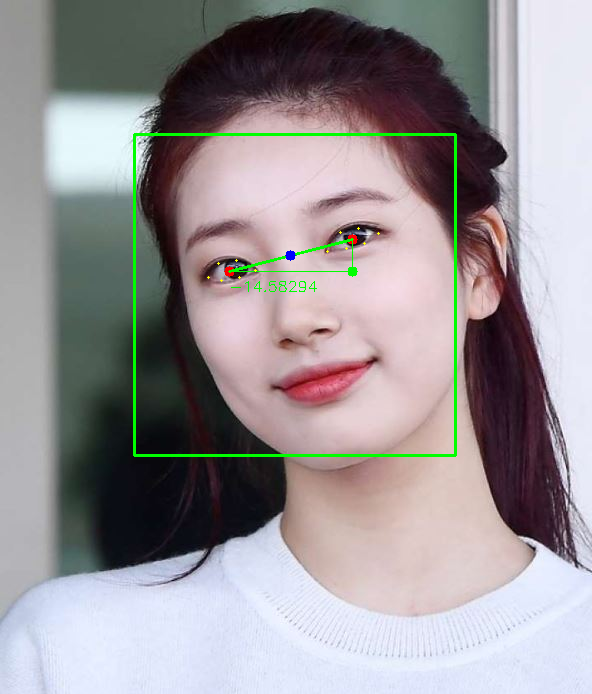


==== rotated image ====



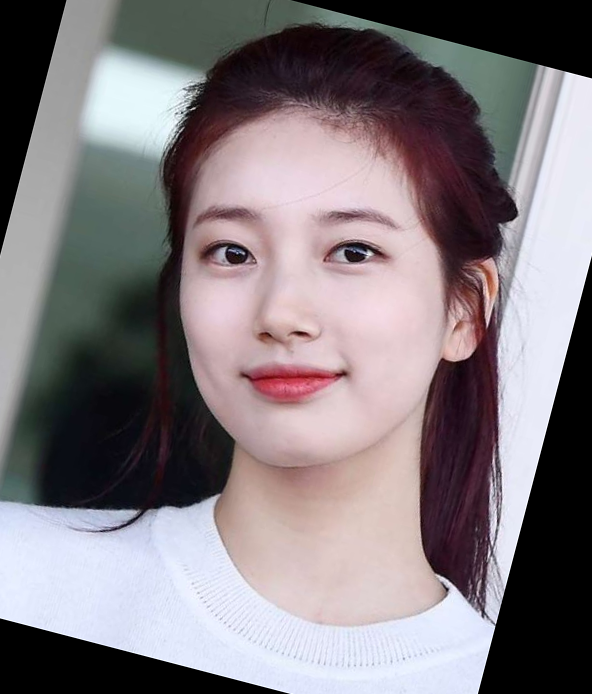


==== croped and resized image ====



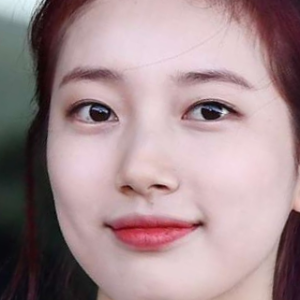

In [ ]:
for (i, rect) in enumerate(rects):
    (x, y, w, h) = getFaceDimension(rect)  # rect 의 x, y, w, h 를 구해온다.
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # 이미지에 boxing

    # predictor 에 의해서 감지된 landmark point 를 x, y 좌표로 계산
    points = np.matrix([[p.x, p.y] for p in predictor(gray, rect).parts()])
    show_parts = points[EYES]

    right_eye_center = np.mean(points[RIGHT_EYE], axis = 0).astype("int")  # 오른쪽 눈의 중앙값 계산
    left_eye_center = np.mean(points[LEFT_EYE], axis = 0).astype("int")    # 왼쪽 눈의 중앙값 계산
     
    cv2.circle(image, (right_eye_center[0,0], right_eye_center[0,1]), 5, (0, 0, 255), -1)  # 오른쪽 눈의 중앙에 점을 찍는다.
    cv2.circle(image, (left_eye_center[0,0], left_eye_center[0,1]), 5, (0, 0, 255), -1)    # 왼쪽 눈의 중앙에 점을 찍는다.
    
    cv2.circle(image, (left_eye_center[0,0], right_eye_center[0,1]), 5, (0, 255, 0), -1)   # 왼쪽 눈의 x좌표와 오른쪽 눈의 y좌표에 점을 찍는다. 
    
    cv2.line(image, (right_eye_center[0,0], right_eye_center[0,1]),    
             (left_eye_center[0,0], left_eye_center[0,1]), (0, 255, 0), 2)  # 오른쪽 눈의 중앙점과 왼쪽 눈의 중앙점 사이에 선을 그린다.
    
    cv2.line(image, (right_eye_center[0,0], right_eye_center[0,1]),
         (left_eye_center[0,0], right_eye_center[0,1]), (0, 255, 0), 1)     # 오른쪽 눈의 중앙점과 왼쪽 눈의 x좌표와 오른쪽 눈의 y좌표 사이에 선을 그린다.
    
    cv2.line(image, (left_eye_center[0,0], right_eye_center[0,1]),
         (left_eye_center[0,0], left_eye_center[0,1]), (0, 255, 0), 1)      # 왼쪽 눈의 중앙점과 왼쪽 눈의 x좌표와 오른쪽 눈의 y좌표 사이에 선을 그린다.  

    eye_delta_x = right_eye_center[0,0] - left_eye_center[0,0]
    eye_delta_y = right_eye_center[0,1] - left_eye_center[0,1]
    degree = np.degrees(np.arctan2(eye_delta_y,eye_delta_x)) - 180        # arctan2 로 조정 각도 계산

    eye_distance = np.sqrt((eye_delta_x ** 2) + (eye_delta_y ** 2))       # 눈 사이의 간격을 Euclidean Distance 로 계산(실제 간격)
    aligned_eye_distance = left_eye_center[0,0] - right_eye_center[0,0]   # alignment 된 눈사이의 간격(조정 거리)
    scale = aligned_eye_distance / eye_distance                           # 조정된 거리의 스케일

    eyes_center = ((left_eye_center[0,0] + right_eye_center[0,0]) // 2,
            (left_eye_center[0,1] + right_eye_center[0,1]) // 2)          # 두 눈의 중앙점 간의 중앙점을 다시 계산 
    cv2.circle(image, eyes_center, 5, (255, 0, 0), -1)                    # 두 눈의 중앙점 간의 중앙점에 점을 찍는다.
            
    cv2.putText(image, "{:.5f}".format(degree), (right_eye_center[0,0], right_eye_center[0,1] + 20),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)                   # 조정 각도를 출력

    for (i, point) in enumerate(show_parts):
        x = point[0,0]
        y = point[0,1]
        cv2.circle(image, (x, y), 1, (0, 255, 255), -1)   # 눈의 위치에 landmark point 를 그린다.

    print("==== face landmark image ====\n")
    cv2_imshow(image)

    rotate = cv2.getRotationMatrix2D(eyes_center, degree, scale)          # 이미지의 센터, 각도(+:반시계, -:시계), 스케일(확대/축소)
    rotated = cv2.warpAffine(image_origin, rotate, (image_width, image_height),
        flags=cv2.INTER_CUBIC)                                            # 원본 이미지 회전 
    
    print("\n==== rotated image ====\n")
    cv2_imshow(rotated)
    
    (startX, endX, startY, endY) = getCropDimension(rect, eyes_center)  # rect 에서 Crop 할 이미지의 좌표값을 구해온다.
    croped = rotated[startY:endY, startX:endX]     # 회전된 이미지에서 Crop 될 이미지를 구한다.
    output = cv2.resize(croped, OUTPUT_SIZE)       # Crop 된 이미지를 Output 해상도에 맞게 resizing

    print("\n==== croped and resized image ====\n")  
    cv2_imshow(output)